In [701]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [702]:
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets.waymo.waymo_dataset_bc import WaymoDatasetBC as WaymoDataset
# from mtr.datasets.waymo.waymo_dataset import WaymoDataset

from tools.mtr_env import BatchMTREnv
from tools.mtr_inference import MTRInference
from tools.mtr_lightning import MTR_Lightning
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical, Independent

cfg = cfg_from_yaml_file('tools/cfgs/waymo/bc+10_percent_data.yaml', cfg)
dataset = WaymoDataset(cfg.DATA_CONFIG, training=False)
env = BatchMTREnv(1, dataset)

model = MTR_Lightning(cfg)
model = model.load_from_checkpoint('output/bc/last.ckpt')
_ = model.cuda()


# Test with dataset

In [704]:
output_mean = model.model.motion_decoder.output_mean
output_std = model.model.motion_decoder.output_std

In [705]:
data = dataset[10]
data_batch = dataset.collate_batch([data])

In [706]:
# model.train()
model.eval()
with torch.no_grad():
    loss, _, output = model.model(data_batch, True)
    center_gt_raw = output['input_dict']['center_gt'][..., :3]
    center_gt = output['input_dict']['center_gt'][...,None, :3].cuda()
    center_gt = (center_gt - output_mean) / output_std
    pred_scores = output['pred_scores']
    pred_ctrls = output['pred_ctrls']

In [709]:
print(pred_ctrls[0, pred_scores[0].argmax()])
print(center_gt[0])


tensor([-0.1417, -0.3771, -0.0743, -3.4169, -3.3540, -3.2015, -0.2392, -0.0178,
         0.6934], device='cuda:0')
tensor([[-0.1084, -0.3507, -0.0801]], device='cuda:0')


In [711]:
# best_idx = (pred_ctrls[...,:3] - center_gt).norm(dim=-1, p=1).argmin(dim=-1)
# print(best_idx)
# pred_ctrls_best = pred_ctrls[torch.arange(pred_ctrls.shape[0]), best_idx]
mode = model.model.motion_decoder.build_mode_distribution(pred_ctrls)
log_p = mode.log_prob(center_gt)
log_p.argmin(dim=-1)
# cls_loss = torch.functional.F.cross_entropy(input=pred_scores, target= best_idx, reduction='none')
# print(cls_loss)

tensor([ 6, 11,  7, 15,  3, 13, 15,  4], device='cuda:0')

In [712]:
_, mode, gmm = model.model.motion_decoder.build_gmm_distribution(pred_ctrls, pred_scores)
log_p = -gmm.log_prob(center_gt.squeeze(1))
log_p

tensor([-4.3976, -5.1087, -2.6351, -4.3375, -3.7922, -4.3874, -3.4114, -1.5612],
       device='cuda:0')

In [768]:
mode, mix, gmm, sample = model.sample(data_batch)
print(sample)
print(center_gt_raw)

[[ 0.621953   -0.07071754  0.01279365]]
tensor([[ 6.6682e-01, -6.7460e-03, -2.9661e-03],
        [ 4.0602e-01, -6.1566e-03, -5.3616e-03],
        [ 2.3488e-01,  4.7285e-03,  2.2769e-03],
        [ 8.8601e-01, -1.0817e-02, -1.4498e-03],
        [ 8.3378e-01,  1.0358e-02,  5.5343e-03],
        [ 1.3114e+00, -1.7099e-03, -1.8388e-04],
        [ 1.1575e+00, -5.7846e-03,  7.3111e-04],
        [ 8.2253e-01,  2.0156e-02,  1.9304e-02]])


# Test in simulation

([<Figure size 800x800 with 2 Axes>],
 [<AxesSubplot: title={'center': 'Scene ee5e5fe91cd6c6e7 at 1.0 seconds'}>])

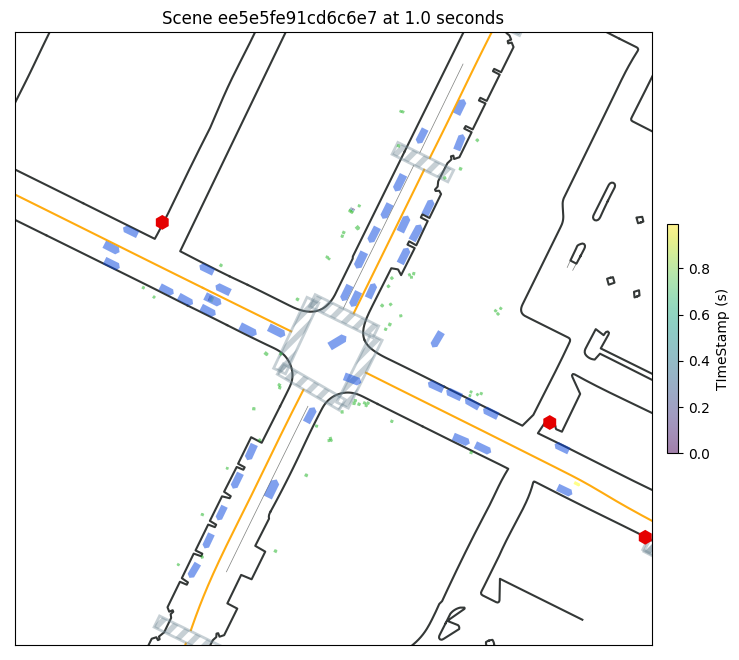

In [769]:
env.reset()
env.visualize()

([<Figure size 800x800 with 2 Axes>],
 [<AxesSubplot: title={'center': 'Scene ee5e5fe91cd6c6e7 at 5.0 seconds'}>])

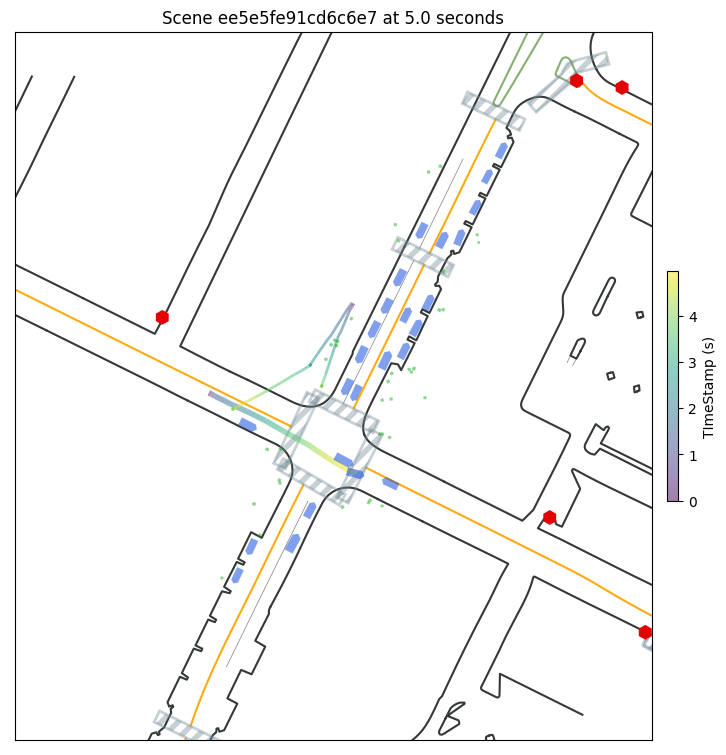

In [773]:
for _ in range(10):
    data_batch = env.batch_scene_data
    action = model.sample(data_batch)[-1]
    _ = env.step(action)
env.visualize()

In [ ]:
from mtr.models.utils import common_layers
import torch

class test(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.query = torch.nn.Parameter(torch.randn((2,4)), requires_grad=True)
        self.model = common_layers.build_mlps(c_in = 4, mlp_channels=[8,4], ret_before_act=True, activation='elu')
        
    def forward(self):
        return self.model(self.query)

model = test()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model.zero_grad()
b = model()
loss = torch.abs(b-1).mean()
loss.backward()
optimizer.step()
print(loss, model.query)
